In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PATH="Assets/Data/"

In [2]:
import json
import pandas as pd

with open(PATH+"swarmData.json", "r") as f:
    data = json.load(f)

rows = []

# Read top-level constants (if you want them in every row)
max_speed = data.get("maxSpeed", None)
max_force = data.get("maxForce", None)
neighbor_radius = data.get("neighborRadius", None)
alpha = data.get("alpha", None)
beta = data.get("beta", None)
delta = data.get("delta", None)
avoidance_radius = data.get("avoidanceRadius", None)
avoidance_force = data.get("avoidanceForce", None)
drone_radius = data.get("droneRadius", None)
damping_factor = data.get("dampingFactor", None)

In [3]:
max_force = 20

In [4]:

rows = []

for drone_entry in data["swarmState"]:
    drone_id = int(drone_entry["droneId"])
    drone_state = drone_entry["droneState"]

    positions = drone_state.get("position", [])
    velocities = drone_state.get("velocity", [])
    obstacles = drone_state.get("obstacleAvoidance", [])
    allignement = drone_state.get("alignment", [])
    olfati = drone_state.get("olfatiSaber", [])
    embodied_list = drone_state.get("embodied", [])
    selected_list = drone_state.get("selected", [])
    network_list = drone_state.get("network", [])

    # Determine how many time steps exist for this drone
    number_of_time_steps = max(
        len(positions),
        len(velocities),
        len(embodied_list),
        len(selected_list),
        len(network_list)
    )

    for i in range(number_of_time_steps):
        # Fetch the position dictionary if it exists, otherwise {}
        if i < len(positions) and isinstance(positions[i], dict):
            pos = positions[i]
            posX = pos.get("x", None)
            posY = pos.get("y", None)
            posZ = pos.get("z", None)
        else:
            posX, posY, posZ = None, None, None

        # Fetch the velocity dictionary if it exists, otherwise {}
        if i < len(velocities) and isinstance(velocities[i], dict):
            vel = velocities[i]
            velX = vel.get("x", None)
            velY = vel.get("y", None)
            velZ = vel.get("z", None)
        else:
            velX, velY, velZ = None, None, None

        if i < len(obstacles) and isinstance(obstacles[i], dict):
            obs = obstacles[i]
            obsX = obs.get("x", None)
            obsY = obs.get("y", None)
            obsZ = obs.get("z", None)

        if i < len(olfati) and isinstance(olfati[i], dict):
            olf = olfati[i]
            olfX = olf.get("x", None)
            olfY = olf.get("y", None)
            olfZ = olf.get("z", None)

        if i < len(allignement) and isinstance(allignement[i], dict):
            all = allignement[i]
            allX = all.get("x", None)
            allY = all.get("y", None)
            allZ = all.get("z", None)

        # Booleans or other single-value lists
        emb = embodied_list[i] if i < len(embodied_list) else None
        sel = selected_list[i] if i < len(selected_list) else None
        net = network_list[i] if i < len(network_list) else None

        row_data = {
            "droneId": drone_id,
            "timeStep": i,
            "posX": posX,
            "posY": posY,
            "posZ": posZ,
            "velX": velX,
            "velY": velY,
            "velZ": velZ,
            "obsX": obsX,
            "obsY": obsY,
            "obsZ": obsZ,
            "olfX": olfX,
            "olfY": olfY,
            "olfZ": olfZ,
            "allX": allX,
            "allY": allY,
            "allZ": allZ,
            "embodied": emb,
            "selected": sel,
            "network": net
        }
        rows.append(row_data)

df = pd.DataFrame(rows)

In [5]:
# fo = Vector3.ClampMagnitude(fo, maxForce);
df['forceMagReal'] = ((df['olfX'] + df['obsX'] + df['allX'])**2 + (df['olfY'] + df['obsY'] + df['allY'])**2 + (df['olfZ'] + df['obsZ'] + df['allZ'])**2)**0.5
df['AppliedForce'] = df['forceMagReal'].apply(lambda x: min(x, max_force))

In [6]:
droneDied = []

lifeLong = df.groupby("droneId").count()[["timeStep"]]
maxLife = lifeLong["timeStep"].max()

for drone in lifeLong.index:
    if lifeLong.loc[drone]["timeStep"] < maxLife:
        droneDied.append([drone, lifeLong.loc[drone]["timeStep"]])



In [7]:
df["crash"] = 0

for drone in droneDied:
    id = drone[0]
    timeStart = int(drone[1] - 100)
    print(id, timeStart)

    df.loc[(df["droneId"] == id) & (df["timeStep"] >= timeStart), "crash"] = 1


5 16246
6 16246
7 16246
8 16246
9 16246
10 16246
11 16246
12 16246
13 16246
14 16246
15 16246
16 16246
17 16246
18 16246
19 16246


In [8]:
dfCrash = df.query("crash == 1")[["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'allX', 'allY', 'allZ', 'forceMagReal', 'AppliedForce', 'droneId']]   
dfHealthy = df.query("crash == 0")[["obsX", "obsY", "obsZ", "olfX", "olfY", "olfZ", 'allX', 'allY', 'allZ', 'forceMagReal', 'AppliedForce', 'droneId']]

In [18]:
df

,droneId,timeStep,posX,posY,posZ,velX,velY,velZ,obsX,obsY,...,olfZ,allX,allY,allZ,embodied,selected,network,forceMagReal,AppliedForce,crash
0,0,0,2.999545,4.883384,-0.000002,-0.022746,0.002079,-1.179303e-04,0.0,0.0,...,-6.016850e-03,0.000000,0.000000,0.000000e+00,False,False,1-4-,1.165364,1.165364,0
1,0,1,2.998652,4.883466,-0.000007,-0.044658,0.004067,-2.305943e-04,0.0,0.0,...,-6.013334e-03,0.019283,-0.002534,1.448321e-04,False,False,1-4-,1.145897,1.145897,0
2,0,2,2.997337,4.883585,-0.000014,-0.065754,0.005967,-3.381644e-04,0.0,0.0,...,-6.006598e-03,0.038538,-0.004953,2.830283e-04,False,False,1-4-,1.126427,1.126427,0
3,0,3,2.995616,4.883740,-0.000023,-0.086049,0.007783,-4.408064e-04,0.0,0.0,...,-5.996704e-03,0.057741,-0.007262,4.147986e-04,False,False,1-4-,1.106967,1.106967,0
4,0,4,2.993505,4.883931,-0.000033,-0.105559,0.009517,-5.386838e-04,0.0,0.0,...,-5.983889e-03,0.076870,-0.009466,5.403479e-04,False,False,1-4-,1.087530,1.087530,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327730,19,16341,0.876888,5.540654,-1.486593,0.000002,-0.000011,-8.641346e-07,0.0,0.0,...,-1.430511e-06,-0.000002,0.000011,1.010085e-06,False,False,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-,0.000014,0.000014,1
327731,19,16342,0.876888,5.540654,-1.486593,0.000002,-0.000011,-8.272429e-07,0.0,0.0,...,0.000000e+00,-0.000002,0.000011,1.000457e-06,False,False,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-,0.000015,0.000015,1
327732,19,16343,0.876888,5.540654,-1.486593,0.000002,-0.000011,-8.105112e-07,0.0,0.0,...,-9.536743e-07,-0.000002,0.000011,9.632083e-07,False,False,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-,0.000014,0.000014,1
327733,19,16344,0.876888,5.540654,-1.486593,0.000002,-0.000011,-8.411681e-07,0.0,0.0,...,-3.337860e-06,-0.000002,0.000011,9.466827e-07,False,False,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-,0.000013,0.000013,1


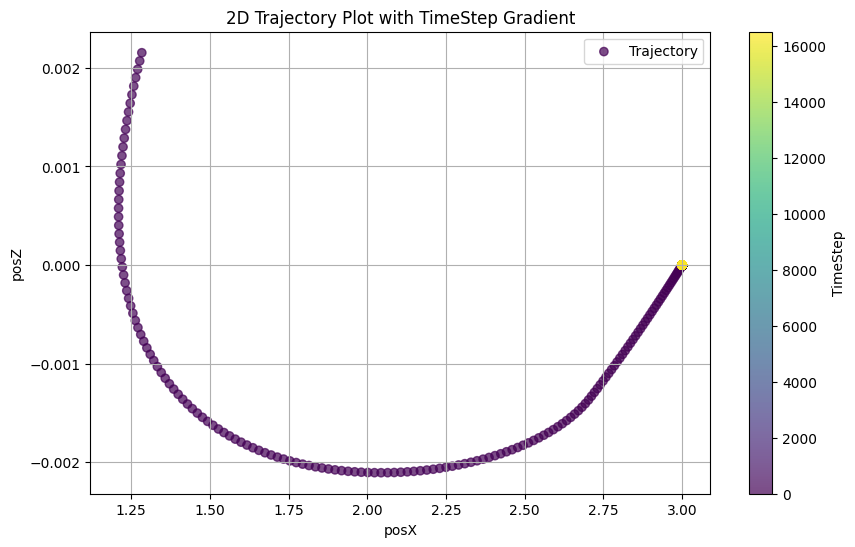

In [25]:
df = df.query("droneId == 0")


plt.figure(figsize=(10, 6))
sc = plt.scatter(df['posX'], df['posZ'], c=df['timeStep'], cmap='viridis', label='Trajectory', alpha=0.7)
plt.colorbar(sc, label='TimeStep')
plt.xlabel('posX')
plt.ylabel('posZ')
plt.title('2D Trajectory Plot with TimeStep Gradient')
plt.legend()
plt.grid(True)
plt.show()



In [10]:
dfHealthy.describe()

,obsX,obsY,obsZ,olfX,olfY,olfZ,allX,allY,allZ,forceMagReal,AppliedForce,droneId
count,326235.000000,326235.000000,3.262350e+05,3.262350e+05,326235.000000,3.262350e+05,326235.000000,326235.000000,326235.000000,3.262350e+05,3.262350e+05,326235.000000
mean,0.000944,0.000125,8.356259e-10,1.401996e-02,-0.000711,2.631241e-05,-0.004909,-0.000229,-0.000102,2.694520e-01,2.003176e-01,9.469769
std,0.115503,0.027114,1.182358e-07,1.725105e+00,2.126329,3.134314e+00,0.196466,0.176349,0.189859,4.119618e+00,1.734095e+00,5.774942
min,0.000000,0.000000,-1.020208e-06,-3.192173e+02,-577.742981,-8.578515e+02,-5.466831,-4.405634,-5.307119,2.005498e-07,2.005498e-07,0.000000
25%,0.000000,0.000000,0.000000e+00,-8.513220e-06,-0.000022,-5.125999e-06,-0.000003,-0.000011,-0.000003,1.013492e-05,1.013492e-05,4.000000
50%,0.000000,0.000000,0.000000e+00,-2.384186e-07,-0.000004,2.682209e-07,0.000000,0.000000,0.000000,1.352404e-05,1.352404e-05,9.000000
75%,0.000000,0.000000,0.000000e+00,7.390976e-06,0.000023,6.437302e-06,0.000005,0.000012,0.000002,1.908645e-05,1.908645e-05,14.000000
max,17.671511,6.237657,2.843969e-05,3.318069e+02,581.650635,8.543553e+02,5.368252,4.517123,5.540174,9.231052e+02,2.000000e+01,19.000000
